In [9]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torcheval.metrics import MultilabelAccuracy
import torch
from prettytable import PrettyTable

In [38]:
df = pd.read_csv("results/openai/openai_result.csv", index_col=0)

In [40]:
df["openai_no_finetune"] = df["openai_no_finetune"].map(lambda x: eval(x))
df["openai_finetuned_200"] = df["openai_finetuned_200"].map(lambda x: eval(x))
df["openai_finetuned"] = df["openai_finetuned"].map(lambda x: eval(x))
df["true_labels"] = df["true_labels"].map(lambda x: eval(x))

In [41]:
df.head()

,text,true_labels,openai_no_finetune,openai_finetuned,openai_finetuned_200
0,bread top notch well,{'food': 'positive'},{},{'food': 'positive'},{'food': 'positive'}
1,say one fastest delivery times city,{'service': 'positive'},{},{'other': 'positive'},{'service': 'positive'}
2,food always fresh ready eat,{'food': 'positive'},{'food': 'positive'},{'food': 'positive'},{'food': 'positive'}
3,mention coffee outstanding,{'food': 'positive'},{},{'food': 'positive'},{'food': 'positive'}
4,trust people go sushi never disappoints,{'other': 'positive'},{},{'other': 'positive'},{'other': 'positive'}


## LLM metrics

In [15]:
def calculate_exact_match_accuracy(df, pred_col_name):
    exact_matches = df.apply(lambda row: row['true_labels'] == row[pred_col_name], axis=1)
    exact_match_accuracy = exact_matches.mean()
    return exact_match_accuracy

def calculate_partial_accuracy(df, pred_col_name):
    def partial_match(row):
        true_keys = set(row['true_labels'].keys())
        pred_keys = set(row[pred_col_name].keys())
        matching_keys = true_keys & pred_keys
        if len(true_keys) == 0:
            return 0
        return len(matching_keys) / len(true_keys)
    
    partial_accuracies = df.apply(partial_match, axis=1)
    partial_accuracy = partial_accuracies.mean()
    return partial_accuracy

def count_extra_keys(df, pred_col_name):
    def extra_key_count(row):
        true_keys = set(row['true_labels'].keys())
        pred_keys = set(row[pred_col_name].keys())
        extra_keys = pred_keys - true_keys
        return len(extra_keys)
    
    extra_keys_counts = df.apply(extra_key_count, axis=1)
    return extra_keys_counts.sum()

def count_rows_with_extra_keys(df, pred_col_name):
    def has_extra_keys(row):
        true_keys = set(row['true_labels'].keys())
        pred_keys = set(row[pred_col_name].keys())
        extra_keys = pred_keys - true_keys
        return len(extra_keys) > 0
    
    rows_with_extra_keys = df.apply(has_extra_keys, axis=1)
    return rows_with_extra_keys.sum()

def count_empty_predicted_labels(df, pred_col):
    empty_predicted_labels = df[pred_col].apply(lambda x: len(x) == 0)
    return empty_predicted_labels.sum()

In [14]:
pred_col = "openai_no_finetune"
print(pred_col)

exact_match_accuracy = calculate_exact_match_accuracy(df, pred_col)
partial_accuracy = calculate_partial_accuracy(df, pred_col)
extra_key_count = count_extra_keys(df, pred_col)
rows_with_extra_keys = count_rows_with_extra_keys(df, pred_col)
empty_predicted_labels_count = count_empty_predicted_labels(df, pred_col)


print(f'Exact Match Accuracy: {exact_match_accuracy}')
print(f'Partial Accuracy: {partial_accuracy}')
print(f'Count of Extra Keys: {extra_key_count}')
print(f'Number of Rows with Extra Keys: {rows_with_extra_keys}')
print(f'Number of Rows with Empty Predicted Labels: {empty_predicted_labels_count}')
print(f'Total: {df.shape[0]}')

openai_no_finetune
Exact Match Accuracy: 0.3417890520694259
Partial Accuracy: 0.4564975522919448
Count of Extra Keys: 43
Number of Rows with Extra Keys: 41
Number of Rows with Empty Predicted Labels: 374
Total: 749


In [22]:
pred_col = "openai_finetuned"
print(pred_col)

exact_match_accuracy = calculate_exact_match_accuracy(df, pred_col)
partial_accuracy = calculate_partial_accuracy(df, pred_col)
extra_key_count = count_extra_keys(df, pred_col)
rows_with_extra_keys = count_rows_with_extra_keys(df, pred_col)
empty_predicted_labels_count = count_empty_predicted_labels(df, pred_col)


print(f'Exact Match Accuracy: {exact_match_accuracy}')
print(f'Partial Accuracy: {partial_accuracy}')
print(f'Count of Extra Keys: {extra_key_count}')
print(f'Number of Rows with Extra Keys: {rows_with_extra_keys}')
print(f'Number of Rows with Empty Predicted Labels: {empty_predicted_labels_count}')
print(f'Total: {df.shape[0]}')

openai_finetuned
Exact Match Accuracy: 0.6955941255006676
Partial Accuracy: 0.8849577214063195
Count of Extra Keys: 86
Number of Rows with Extra Keys: 83
Number of Rows with Empty Predicted Labels: 0
Total: 749


In [42]:
pred_col = "openai_finetuned_200"
print(pred_col)

exact_match_accuracy = calculate_exact_match_accuracy(df, pred_col)
partial_accuracy = calculate_partial_accuracy(df, pred_col)
extra_key_count = count_extra_keys(df, pred_col)
rows_with_extra_keys = count_rows_with_extra_keys(df, pred_col)
empty_predicted_labels_count = count_empty_predicted_labels(df, pred_col)


print(f'Exact Match Accuracy: {exact_match_accuracy}')
print(f'Partial Accuracy: {partial_accuracy}')
print(f'Count of Extra Keys: {extra_key_count}')
print(f'Number of Rows with Extra Keys: {rows_with_extra_keys}')
print(f'Number of Rows with Empty Predicted Labels: {empty_predicted_labels_count}')
print(f'Total: {df.shape[0]}')

openai_finetuned_200
Exact Match Accuracy: 0.6835781041388518
Partial Accuracy: 0.8846239430351579
Count of Extra Keys: 117
Number of Rows with Extra Keys: 113
Number of Rows with Empty Predicted Labels: 0
Total: 749


## Loss plot

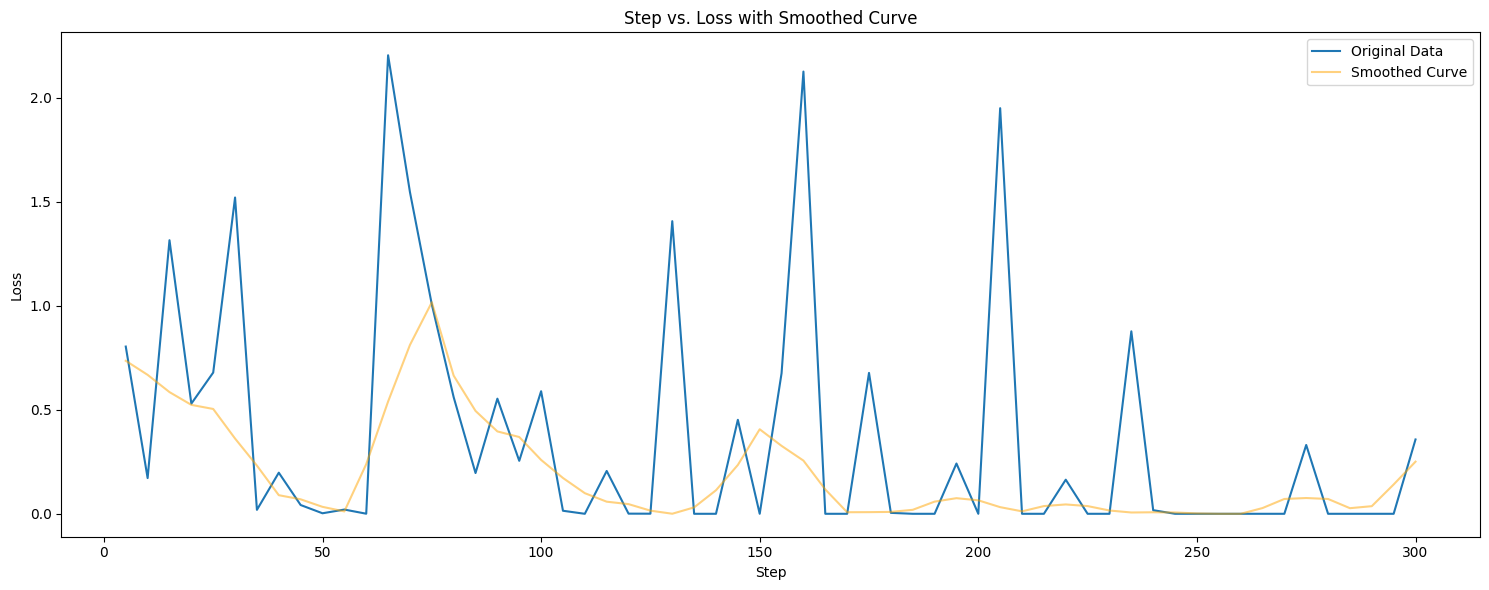

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "results/openai/openai_finetuning_loss.csv"
data = pd.read_csv(file_path)


# Filter the data to include only every 10th step
filtered_data = data[data['step'] % 5 == 0]

# Create the Seaborn plot
plt.figure(figsize=(15, 6))
sns.lineplot(x='step', y='loss', data=filtered_data, label='Original Data')

# Apply LOWESS smoothing
smoothed = lowess(filtered_data['loss'], filtered_data['step'], frac=0.1)
smoothed_df = pd.DataFrame(smoothed, columns=['step', 'loss'])

# Plot the smoothed curve with lighter opacity
sns.lineplot(x='step', y='loss', data=smoothed_df, label='Smoothed Curve', color='orange', alpha=0.5)

# Add labels and title
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Step vs. Loss with Smoothed Curve')
plt.legend()
plt.tight_layout()
plt.savefig("openai_loss_plot.png")
plt.show()